In [32]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import itertools

In [18]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [19]:
batch_size_train=60
batch_size_test=1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./files', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307, ), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True
)

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [22]:
example_data.shape

torch.Size([1000, 1, 28, 28])

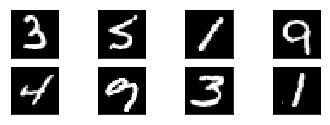

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.xticks([])
    plt.yticks([])

plt.show()

## Build Network

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    


## Initalize Network and Optimizer

In [26]:
learning_rate = 0.01
epochs = 3
log_interval = 10


network = Net().to("cpu")
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

## Training Model

In [47]:
def train(device):
    network.train() #set network to training mode
        
    batch_idx = -1
    for (data, target) in itertools.islice(train_loader, 20):
        batch_idx += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()
        ))

## Test Function

In [45]:
test_losses = []

def test(device):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in itertools.islice(test_loader, 100):
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

## Test with CPU

In [48]:
import time
start_time = time.time()

test("cpu")
for epoch in range(epochs):
    train("cpu")
    test("cpu")
    
print("CPU took %s seconds" % (time.time() - start_time))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/pi/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2780, Accuracy: 1676/10000 (16%)

Train Epoch: 0 [0/60000 (0.00%)]	Loss: 2.292901
Train Epoch: 0 [60/60000 (0.10%)]	Loss: 2.278861
Train Epoch: 0 [120/60000 (0.20%)]	Loss: 2.289899
Train Epoch: 0 [180/60000 (0.30%)]	Loss: 2.265180
Train Epoch: 0 [240/60000 (0.40%)]	Loss: 2.282387
Train Epoch: 0 [300/60000 (0.50%)]	Loss: 2.273142
Train Epoch: 0 [360/60000 (0.60%)]	Loss: 2.255084
Train Epoch: 0 [420/60000 (0.70%)]	Loss: 2.260707
Train Epoch: 0 [480/60000 (0.80%)]	Loss: 2.267540
Train Epoch: 0 [540/60000 (0.90%)]	Loss: 2.273759
Train Epoch: 0 [600/60000 (1.00%)]	Loss: 2.261919
Train Epoch: 0 [660/60000 (1.10%)]	Loss: 2.266442
Train Epoch: 0 [720/60000 (1.20%)]	Loss: 2.254170
Train Epoch: 0 [780/60000 (1.30%)]	Loss: 2.267563
Train Epoch: 0 [840/60000 (1.40%)]	Loss: 2.286077
Train Epoch: 0 [900/60000 (1.50%)]	Loss: 2.272125
Train Epoch: 0 [960/60000 (1.60%)]	Loss: 2.279553
Train Epoch: 0 [1020/60000 (1.70%)]	Loss: 2.278034
Train Epoch: 0 [1080/60000 (1.80%)]	Loss: 2.